In [1]:
import torch
import torchvision
from torchvision import transforms, datasets
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision.models import resnet18

In [2]:
dataset_dir = "../dataset_output/lsa64_images/imgs/"
# dataset_dir = "../dataset_output/libras_minds/imgs/"

In [6]:
# Define image transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
#     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [4]:
# Load dataset
dataset = datasets.ImageFolder(root=dataset_dir, transform=transform)

In [5]:
# Split dataset into train and test
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

In [7]:
# Define data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

NameError: name 'train_dataset' is not defined

In [7]:
# Load pre-trained ResNet18 model
resnet = resnet18(pretrained=True)

/home/dudu/anaconda3/envs/tf/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/dudu/anaconda3/envs/tf/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [9]:
num_ftrs = resnet.fc.in_features

In [10]:
# Modify the fully connected layer to match the number of classes
resnet.fc = nn.Linear(num_ftrs, 64)

In [11]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet.parameters(), lr=0.004)

In [12]:
# Train the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
resnet.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [14]:
from datetime import datetime

In [16]:
epochs = 10
history = {"loss": [], "accuracy": []}
for epoch in range(epochs):
    resnet.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = resnet(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
    epoch_loss = running_loss / len(train_loader.dataset)
    
    resnet.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = resnet(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = correct / total
    history["loss"].append(loss)
    history["accuracy"].append(accuracy)
    
    print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss:.4f}, Accuracy: {accuracy:.4f}")
    print(str(datetime.now()))

Epoch 1/10, Loss: 0.1093, Accuracy: 0.9159
2024-03-07 19:30:39.650106
Epoch 2/10, Loss: 0.1073, Accuracy: 0.9556
2024-03-07 19:31:10.689781
Epoch 3/10, Loss: 0.0771, Accuracy: 0.9556
2024-03-07 19:31:41.845422
Epoch 4/10, Loss: 0.0525, Accuracy: 0.9529
2024-03-07 19:32:13.948647
Epoch 5/10, Loss: 0.0828, Accuracy: 0.9032
2024-03-07 19:32:45.505572
Epoch 6/10, Loss: 0.0690, Accuracy: 0.9603
2024-03-07 19:33:16.133535
Epoch 7/10, Loss: 0.0497, Accuracy: 0.9637
2024-03-07 19:33:47.162787
Epoch 8/10, Loss: 0.0375, Accuracy: 0.9630
2024-03-07 19:34:18.269180
Epoch 9/10, Loss: 0.0359, Accuracy: 0.9684
2024-03-07 19:34:49.244621
Epoch 10/10, Loss: 0.0733, Accuracy: 0.9375
2024-03-07 19:35:19.672154


In [18]:
resnet.eval()
correct = 0
total = 0
class_correct = list(0. for _ in range(64))
class_total = list(0. for _ in range(64))

In [19]:
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = resnet(inputs)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        c = (predicted == labels).squeeze()
        for i in range(len(labels)):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

In [20]:
accuracy = correct / total
print(f"Accuracy on the test set: {accuracy:.4f}")

Accuracy on the test set: 0.9375


In [21]:
from matplotlib import pyplot as plt

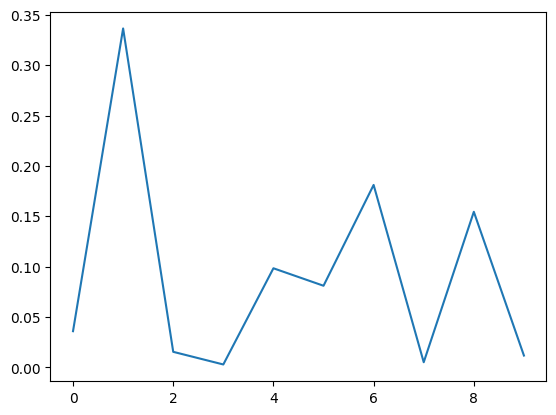

In [30]:
plt.plot([float(l) for l in history["loss"]])